<a id='top'></a>
# COVID-19 ANALYSIS


**Table of contents**
* [1. Introduction](#step0)
* [2. Data gathering and wrangling](#step1)
    * [2.1 Collect data on COVID-19](#step1a)
    * [2.2. Collect country code information](#step1b)
    * [2.3. Collect indicators](#step1c)
        * [2.3.1. WorldBank](#step1c1)
        * [2.3.2. OECD](#step1c2)
    * [2.4. Select and aggregate indicators](#step1d)
    * [2.5. Data clean up](#step1e)
* [3. Data exploration and visualization](#step2)
    * [3.1. Confirmed cases and depths per country](#step2a)
    * [3.2. Case fatality rate - CFR](#step2b)
    * [3.3. CFR correlation of indicators](#step2b)
* [4. Analysis and conclusions](#step3)
* [5. Resources](#step4)



<a id='step0'></a>
## 1. Introduction

In this notebook the reported number of cases and deaths in the COVID-19 outbreak is evaluated to answer the follwoing questions:
1. What is the case fatality rate (CFR) of COVID-19?
2. Is there a significant variation of CFR for COVID-19 among different countries?
3. What country-specific features might affect the case fatality rate?

The data is evaluated and the results used to answer these question on the [analysis and conclusions](#step3).

[Back to top](#top)

---
<a id='step1'></a>
## 2. Data gathering and wrangling


In [1]:
# IMPORT LIBRARIES DEPENDENCIES
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='step1a'></a>
### 2.1. Collect data on COVID-19

In [2]:
alpha2Code = []
name = []
total = []
death = []
recov = []

query = 'https://api.covid19api.com/summary'
response = requests.get(query)
if response.status_code != 200:
    raise "Error in retrieving data from API"
data = response.json()

for country in data['Countries']:

    name.append(country['Country'])
    alpha2Code.append(country['CountryCode'])
    total.append(country['TotalConfirmed'])
    death.append(country['TotalDeaths'])
    recov.append(country['TotalRecovered'])

df = pd.DataFrame(data={'Country':   name,
                        'alpha2Code': alpha2Code,
                        'Covid19_total':     total,
                        'Covid19_deaths':    death,
                        'Covid19_recovered': recov})

df['Covid19_active'] = df['Covid19_total']-df['Covid19_recovered']
df['Covid19_fatality'] = df['Covid19_deaths']/df['Covid19_total']
df.sort_values(by='Covid19_total',ascending=False,inplace=True)
df = df.reset_index(drop=True)
df.head(10)

,Country,alpha2Code,Covid19_total,Covid19_deaths,Covid19_recovered,Covid19_active,Covid19_fatality
0,United States of America,US,987068,56221,111424,875644,0.056958
1,Spain,ES,229422,23521,120832,108590,0.102523
2,Italy,IT,199414,26977,66624,132790,0.135281
3,France,FR,165963,23327,46293,119670,0.140555
4,Germany,DE,158758,6126,114500,44258,0.038587
5,United Kingdom,GB,158348,21157,807,157541,0.133611
6,Turkey,TR,112261,2900,33791,78470,0.025833
7,"Iran, Islamic Republic of",IR,91472,5806,70933,20539,0.063473
8,Russian Federation,RU,87147,794,7346,79801,0.009111
9,China,CN,83918,4637,78374,5544,0.055256


In [3]:
# Drop rows with NaNs
df.dropna(inplace=True)

In [4]:
# Countries with no deaths reported might indicate failure in reports.
# Droping these countries from results.
df = df[df.Covid19_deaths>0]

In [5]:
# Check fatality for whole data set
sample_fatality = df['Covid19_deaths'].sum()/df['Covid19_total'].sum()
print("Fatality rate")
print(f"   Sample size: {df.shape[0]}")
print(f"   Sample mean: {sample_fatality:.3f}")
print(f"   Countries mean (std): {df['Covid19_fatality'].mean():.3f} +- {df['Covid19_fatality'].std():.3f}")
print(f"   Countries min/max: {df['Covid19_fatality'].min():.3f} / {df['Covid19_fatality'].max():.3f}")

Fatality rate
   Sample size: 154
   Sample mean: 0.069
   Countries mean (std): 0.045 +- 0.039
   Countries min/max: 0.001 / 0.231


In [6]:
# Check countries with highest fatality rates
df.sort_values(by='Covid19_fatality',ascending=False).head(5)

,Country,alpha2Code,Covid19_total,Covid19_deaths,Covid19_recovered,Covid19_active,Covid19_fatality
170,Nicaragua,NI,13,3,7,6,0.230769
12,Belgium,BE,46687,7207,10878,35809,0.154368
178,Mauritania,MR,7,1,6,1,0.142857
3,France,FR,165963,23327,46293,119670,0.140555
140,Bahamas,BS,80,11,22,58,0.137500


In [7]:
# Total number of confirmed cases is very low in some countries, 
# impacting the staistics for fatality.
# Filtering data to countries with more then 10000 cases.
df = df[df.Covid19_total>10000]

In [8]:
df.sort_values(by='Covid19_fatality',ascending=False).head(10)

,Country,alpha2Code,Covid19_total,Covid19_deaths,Covid19_recovered,Covid19_active,Covid19_fatality
12,Belgium,BE,46687,7207,10878,35809,0.154368
3,France,FR,165963,23327,46293,119670,0.140555
2,Italy,IT,199414,26977,66624,132790,0.135281
5,United Kingdom,GB,158348,21157,807,157541,0.133611
20,Sweden,SE,18926,2274,1005,17921,0.120152
13,Netherlands,NL,38440,4534,117,38323,0.117950
1,Spain,ES,229422,23521,120832,108590,0.102523
23,Mexico,MX,15529,1434,9086,6443,0.092343
10,Brazil,BR,67446,4603,31142,36304,0.068247
7,"Iran, Islamic Republic of",IR,91472,5806,70933,20539,0.063473


In [9]:
# CHECK FATALITY FOR COUNTRIES WITH MORE THAN 10,000 CAES
sample_fatality = df['Covid19_deaths'].sum()/df['Covid19_total'].sum()
print("Fatality rate")
print(f"   Sample size: {df.shape[0]}")
print(f"   Sample mean: {sample_fatality:.3f}")
print(f"   Countries mean (std): {df['Covid19_fatality'].mean():.3f} +- {df['Covid19_fatality'].std():.3f}")
print(f"   Countries min/max: {df['Covid19_fatality'].min():.3f} / {df['Covid19_fatality'].max():.3f}")

Fatality rate
   Sample size: 35
   Sample mean: 0.072
   Countries mean (std): 0.054 +- 0.044
   Countries min/max: 0.001 / 0.154


<a id='step1b'></a>
### 2.2. Collect country code information

In [10]:
# Create Europe data frame
query = 'https://restcountries.eu/rest/v2/region/europe'
response = requests.get(query)
if response.status_code != 200:
    raise "Error in retrieving data from API"
data = response.json()

alpha2Code = []
alpha3Code = []
population = []
borders = []
name = []
subregion = []

for country in data:
    alpha2Code.append(country['alpha2Code'])
    alpha3Code.append(country['alpha3Code'])
    population.append(country['population'])
    borders.append(country['borders'])
    name.append(country['name'])
    subregion.append(country['subregion'])

df_europe = pd.DataFrame({'Country':       name,
                          'alpha2Code': alpha2Code,
                          'alpha3Code': alpha3Code,
                          'Population': population,
                          'Borders':    borders,
                          'Subregion':  subregion})

df_europe.sort_values(by='Population',ascending=False,inplace=True)
df_europe = df_europe.reset_index(drop=True)
df_europe.head()

,Country,alpha2Code,alpha3Code,Population,Borders,Subregion
0,Russian Federation,RU,RUS,146599183,"[AZE, BLR, CHN, EST, FIN, GEO, KAZ, PRK, LVA, ...",Eastern Europe
1,Germany,DE,DEU,81770900,"[AUT, BEL, CZE, DNK, FRA, LUX, NLD, POL, CHE]",Western Europe
2,France,FR,FRA,66710000,"[AND, BEL, DEU, ITA, LUX, MCO, ESP, CHE]",Western Europe
3,United Kingdom of Great Britain and Northern I...,GB,GBR,65110000,[IRL],Northern Europe
4,Italy,IT,ITA,60665551,"[AUT, FRA, SMR, SVN, CHE, VAT]",Southern Europe


In [11]:
# check for NaNs
df_europe[np.any(df_europe.isna(),axis=1)].shape[0]

0

In [12]:
# Merge data frame of COVID-19 cases on data frame for Europe
df2 = df.merge(df_europe.drop('Country',axis=1),how='inner',on='alpha2Code')
df2.shape[0]

16

In [13]:
# CHECK FATALITY IN EUROPE
df2[['Country','Subregion','Covid19_total','Covid19_deaths','Covid19_recovered','Covid19_fatality']].sort_values(by="Covid19_fatality",ascending=False)

,Country,Subregion,Covid19_total,Covid19_deaths,Covid19_recovered,Covid19_fatality
6,Belgium,Western Europe,46687,7207,10878,0.154368
2,France,Western Europe,165963,23327,46293,0.140555
1,Italy,Southern Europe,199414,26977,66624,0.135281
4,United Kingdom,Northern Europe,158348,21157,807,0.133611
11,Sweden,Northern Europe,18926,2274,1005,0.120152
7,Netherlands,Western Europe,38440,4534,117,0.117950
0,Spain,Southern Europe,229422,23521,120832,0.102523
8,Switzerland,Western Europe,29164,1665,22200,0.057091
14,Romania,Eastern Europe,11339,641,3141,0.056531
10,Ireland,Northern Europe,19648,1102,9233,0.056087


In [14]:
# Droping Russia and Belarus from analysis (clearly an outlier on the data set for fatality rate)
df2 = df2.query("alpha2Code != 'RU' & alpha2Code != 'BY'").reset_index(drop=True)

In [15]:
# CHECK FATALITY FOR SUBSET OF COUNTRIES
sample_fatality = df2['Covid19_deaths'].sum()/df2['Covid19_total'].sum()
print("Fatality rate")
print(f"   Sample size: {df2.shape[0]}")
print(f"   Sample mean: {sample_fatality:.3f}")
print(f"   Countries mean (std): {df2['Covid19_fatality'].mean():.3f} +- {df2['Covid19_fatality'].std():.3f}")
print(f"   Countries min/max: {df2['Covid19_fatality'].min():.3f} / {df2['Covid19_fatality'].max():.3f}")

Fatality rate
   Sample size: 14
   Sample mean: 0.107
   Countries mean (std): 0.088 +- 0.045
   Countries min/max: 0.036 / 0.154


<a id='step1c'></a>
### 2.3. Collect indicators

<a id='step1c1'></a>
#### 2.3.1 WorldBank

In [16]:
# Pull indicators from WorldBank (data from 2010)
per_page = 2000
indicators = ['NY.GDP.PCAP.CD',  # 'GDP per capita (current US$)'
              'SH.MED.BEDS.ZS', # 'Hospital beds (per 1,000 people)'
             ]
countries = ';'.join([val for val in df2.alpha3Code])
year = 2010

map_indicator_worldbank = dict()

df_indicators_worldBank = pd.DataFrame({'alpha3Code':[]})

for indicator in indicators:
    query = f"http://api.worldbank.org/v2/country/{countries}/indicator/{indicator}?date={year}&format=json&per_page={per_page}"
    values = []
    codes= []
    response = requests.get(query)
    if response.status_code != 200:
        raise "Error in retrieving data from API"
    data = response.json()
    for value_per_country in data[1]:
        values.append(value_per_country['value'])
        codes.append(value_per_country['countryiso3code'])
        map_indicator_worldbank[indicator] = value_per_country['indicator']['value']

    df_indicators_worldBank = df_indicators_worldBank.merge(pd.DataFrame({'alpha3Code': codes,
                                             indicator.replace('.','_'): values}),
                                                            on='alpha3Code',
                                                            how='outer')
df_indicators_worldBank.head()

,alpha3Code,NY_GDP_PCAP_CD,SH_MED_BEDS_ZS
0,AUT,46858.043273,7.7
1,BEL,44141.878142,6.5
2,CHE,74605.774509,5.0
3,DEU,41531.934198,8.2
4,ESP,30502.719708,3.2


<a id='step1c2'></a>
#### 2.3.2 OECD

In [17]:
# Pull indicators from OECD
# indicators from OECD
sdmx_query_list = [{'dataset': 'HEALTH_REAC',
                   'variables': 'PHYSMEDE+MINUINFI+HOEM+HOEMHEMP+HOSP+HOPI.DENSPPNB'},
                   {'dataset': 'HEALTH_STAT',
                   'variables': 'CICDINPN+CICDPNEU+CICDBAEM+CICDASMA.NBPOPUPC'}]

countries = '+'.join([val for val in df2.alpha3Code])

df_oecd = pd.DataFrame()
for params in sdmx_query_list:
    sdmx_query = f"{params['dataset']}/{params['variables']}.{countries}"
    df_temp = pd.read_csv(f"https://stats.oecd.org/SDMX-JSON/data/{sdmx_query}?contentType=csv")
    df_temp = df_temp.drop(["Flag Codes","Flags","YEA"],axis=1).query("Year >= 2013")
    df_oecd = df_oecd.append(df_temp)

df_oecd.head(10)

,VAR,Variable,UNIT,Measure,COU,Country,Year,Value
53,PHYSMEDE,Practising physicians,DENSPPNB,Density per 1 000 population (head counts),AUT,Austria,2013,4.99
54,PHYSMEDE,Practising physicians,DENSPPNB,Density per 1 000 population (head counts),AUT,Austria,2014,5.05
55,PHYSMEDE,Practising physicians,DENSPPNB,Density per 1 000 population (head counts),AUT,Austria,2015,5.09
56,PHYSMEDE,Practising physicians,DENSPPNB,Density per 1 000 population (head counts),AUT,Austria,2016,5.13
57,PHYSMEDE,Practising physicians,DENSPPNB,Density per 1 000 population (head counts),AUT,Austria,2017,5.18
86,MINUINFI,Practising nurses,DENSPPNB,Density per 1 000 population (head counts),AUT,Austria,2013,6.69
87,MINUINFI,Practising nurses,DENSPPNB,Density per 1 000 population (head counts),AUT,Austria,2014,6.79
88,MINUINFI,Practising nurses,DENSPPNB,Density per 1 000 population (head counts),AUT,Austria,2015,6.80
89,MINUINFI,Practising nurses,DENSPPNB,Density per 1 000 population (head counts),AUT,Austria,2016,6.77
90,MINUINFI,Practising nurses,DENSPPNB,Density per 1 000 population (head counts),AUT,Austria,2017,6.85


In [18]:
# indicators from OECD
countries = '+'.join([val for val in df2.alpha3Code])
sdmx_query = f"SHA/HFTOT+HF1+HF2+HF3.HCTOT.HPTOT.PARPIB.{countries}"
df_oecd2 = pd.read_csv(f"https://stats.oecd.org/SDMX-JSON/data/{sdmx_query}?contentType=csv")
df_oecd2 = df_oecd2.drop(["Flags",
                          "Flag Codes",
                          "PowerCode Code",
                          "TIME",
                          "Unit Code",
                          "HP",
                          "HC",
                          "Provider",
                          "Reference Period Code",
                          "Reference Period",
                          "PowerCode"],axis=1).query("Year >= 2013")
df_oecd2.head(10)

,HF,Financing scheme,Function,MEASURE,Measure,LOCATION,Country,Year,Unit,Value
27,HFTOT,All financing schemes,Current expenditure on health (all functions),PARPIB,Share of gross domestic product,FRA,France,2013,Percentage,11.436
28,HFTOT,All financing schemes,Current expenditure on health (all functions),PARPIB,Share of gross domestic product,FRA,France,2014,Percentage,11.571
29,HFTOT,All financing schemes,Current expenditure on health (all functions),PARPIB,Share of gross domestic product,FRA,France,2015,Percentage,11.459
30,HFTOT,All financing schemes,Current expenditure on health (all functions),PARPIB,Share of gross domestic product,FRA,France,2016,Percentage,11.479
31,HFTOT,All financing schemes,Current expenditure on health (all functions),PARPIB,Share of gross domestic product,FRA,France,2017,Percentage,11.313
32,HFTOT,All financing schemes,Current expenditure on health (all functions),PARPIB,Share of gross domestic product,FRA,France,2018,Percentage,11.177
58,HFTOT,All financing schemes,Current expenditure on health (all functions),PARPIB,Share of gross domestic product,ITA,Italy,2013,Percentage,8.952
59,HFTOT,All financing schemes,Current expenditure on health (all functions),PARPIB,Share of gross domestic product,ITA,Italy,2014,Percentage,9.011
60,HFTOT,All financing schemes,Current expenditure on health (all functions),PARPIB,Share of gross domestic product,ITA,Italy,2015,Percentage,8.988
61,HFTOT,All financing schemes,Current expenditure on health (all functions),PARPIB,Share of gross domestic product,ITA,Italy,2016,Percentage,8.881


<a id='step1d2'></a>
### 2.4. Select and aggregate indicators

In [19]:
#df_indicators_worldBank
for key,value in map_indicator_worldbank.items():
    print(key,value)

NY.GDP.PCAP.CD GDP per capita (current US$)
SH.MED.BEDS.ZS Hospital beds (per 1,000 people)


In [20]:
# check all countries are in the data
np.setdiff1d(df2['alpha3Code'].unique(),df_indicators_worldBank['alpha3Code'].unique())

array([], dtype=object)

In [21]:
# Aggregate WorldBankd indicators to COVID-19 data
df_agg = df2.merge(df_indicators_worldBank,how='left',on='alpha3Code')
df_agg.head()

,Country,alpha2Code,Covid19_total,Covid19_deaths,Covid19_recovered,Covid19_active,Covid19_fatality,alpha3Code,Population,Borders,Subregion,NY_GDP_PCAP_CD,SH_MED_BEDS_ZS
0,Spain,ES,229422,23521,120832,108590,0.102523,ESP,46438422,"[AND, FRA, GIB, PRT, MAR]",Southern Europe,30502.719708,3.2
1,Italy,IT,199414,26977,66624,132790,0.135281,ITA,60665551,"[AUT, FRA, SMR, SVN, CHE, VAT]",Southern Europe,36000.520118,3.6
2,France,FR,165963,23327,46293,119670,0.140555,FRA,66710000,"[AND, BEL, DEU, ITA, LUX, MCO, ESP, CHE]",Western Europe,40638.334004,6.6
3,Germany,DE,158758,6126,114500,44258,0.038587,DEU,81770900,"[AUT, BEL, CZE, DNK, FRA, LUX, NLD, POL, CHE]",Western Europe,41531.934198,8.2
4,United Kingdom,GB,158348,21157,807,157541,0.133611,GBR,65110000,[IRL],Northern Europe,39435.839902,3.0


In [22]:
# check all countries are in the data
no_data = np.setdiff1d(df2['alpha3Code'].unique(),df_oecd['COU'].unique())
print("Countries not in OECD dataset")              
df2[df2["alpha3Code"].isin(no_data)]["Country"]

Countries not in OECD dataset


13    Romania
Name: Country, dtype: object

In [23]:
# Check indicators from df_oecd
df_oecd[['VAR','UNIT','Variable','Measure']].drop_duplicates()

,VAR,UNIT,Variable,Measure
53,PHYSMEDE,DENSPPNB,Practising physicians,Density per 1 000 population (head counts)
86,MINUINFI,DENSPPNB,Practising nurses,Density per 1 000 population (head counts)
104,HOEMHEMP,DENSPPNB,Total hospital employment,Density per 1 000 population (head counts)
53,CICDINPN,NBPOPUPC,Influenza,Number of total deaths
111,CICDBAEM,NBPOPUPC,Chronic obstructive Pulmonary diseases,Number of total deaths
169,CICDPNEU,NBPOPUPC,Pneumonia,Number of total deaths
185,CICDASMA,NBPOPUPC,Asthma,Number of total deaths


In [24]:
# Selecting data from 2015 (data from 2016 onwards are less complete)
df_oecd = df_oecd.query("Year == 2015")[["COU","VAR","Value"]].pivot(index="COU",
                        columns="VAR",
                        values="Value")

# check for NaNs
print("Number of NaNs:",df_oecd.isna().sum())
df_oecd

Number of NaNs: VAR
CICDASMA    0
CICDBAEM    0
CICDINPN    0
CICDPNEU    0
HOEMHEMP    2
MINUINFI    3
PHYSMEDE    1
dtype: int64


VAR,CICDASMA,CICDBAEM,CICDINPN,CICDPNEU,HOEMHEMP,MINUINFI,PHYSMEDE
COU,,,,,,,
AUT,58.0,2889.0,61.0,936.0,13.29,6.80,5.09
BEL,125.0,4527.0,308.0,4120.0,18.49,10.83,3.02
CHE,85.0,2024.0,219.0,1469.0,24.40,16.58,4.20
DEU,1052.0,33997.0,570.0,20173.0,16.10,12.65,4.14
ESP,1134.0,15199.0,474.0,10209.0,11.76,5.29,3.85
FRA,853.0,10209.0,1628.0,13167.0,19.55,NaN,3.12
GBR,1469.0,33133.0,374.0,32333.0,20.57,7.91,2.77
IRL,74.0,1576.0,32.0,1165.0,12.65,NaN,2.86
ITA,423.0,21934.0,574.0,11632.0,10.29,5.44,3.84


In [25]:
# Aggregate OECD indicators to COVID-19 data
df_agg = df_agg.merge(df_oecd,how='left',right_on='COU',left_on='alpha3Code')
df_agg.head()

,Country,alpha2Code,Covid19_total,Covid19_deaths,Covid19_recovered,Covid19_active,Covid19_fatality,alpha3Code,Population,Borders,Subregion,NY_GDP_PCAP_CD,SH_MED_BEDS_ZS,CICDASMA,CICDBAEM,CICDINPN,CICDPNEU,HOEMHEMP,MINUINFI,PHYSMEDE
0,Spain,ES,229422,23521,120832,108590,0.102523,ESP,46438422,"[AND, FRA, GIB, PRT, MAR]",Southern Europe,30502.719708,3.2,1134.0,15199.0,474.0,10209.0,11.76,5.29,3.85
1,Italy,IT,199414,26977,66624,132790,0.135281,ITA,60665551,"[AUT, FRA, SMR, SVN, CHE, VAT]",Southern Europe,36000.520118,3.6,423.0,21934.0,574.0,11632.0,10.29,5.44,3.84
2,France,FR,165963,23327,46293,119670,0.140555,FRA,66710000,"[AND, BEL, DEU, ITA, LUX, MCO, ESP, CHE]",Western Europe,40638.334004,6.6,853.0,10209.0,1628.0,13167.0,19.55,NaN,3.12
3,Germany,DE,158758,6126,114500,44258,0.038587,DEU,81770900,"[AUT, BEL, CZE, DNK, FRA, LUX, NLD, POL, CHE]",Western Europe,41531.934198,8.2,1052.0,33997.0,570.0,20173.0,16.10,12.65,4.14
4,United Kingdom,GB,158348,21157,807,157541,0.133611,GBR,65110000,[IRL],Northern Europe,39435.839902,3.0,1469.0,33133.0,374.0,32333.0,20.57,7.91,2.77


In [26]:
#df_oecd2
df_oecd2["VAR"] = df_oecd2["MEASURE"] + "_"+ df_oecd2["HF"]
df_oecd2[['VAR','Function','Financing scheme','Measure']].drop_duplicates()

,VAR,Function,Financing scheme,Measure
27,PARPIB_HFTOT,Current expenditure on health (all functions),All financing schemes,Share of gross domestic product
189,PARPIB_HF1,Current expenditure on health (all functions),Government/compulsory schemes,Share of gross domestic product
351,PARPIB_HF2,Current expenditure on health (all functions),Voluntary health care payment schemes,Share of gross domestic product
449,PARPIB_HF3,Current expenditure on health (all functions),Household out-of-pocket payments,Share of gross domestic product


In [27]:
# select data from 2017
df_oecd2 = df_oecd2.query("Year == 2017")[["LOCATION","VAR","Value"]]
df_oecd2 = df_oecd2.pivot(index="LOCATION",columns="VAR",values="Value")
df_oecd2

VAR,PARPIB_HF1,PARPIB_HF2,PARPIB_HF3,PARPIB_HFTOT
LOCATION,,,,
AUT,7.694,0.706,1.996,10.397
BEL,7.986,0.529,1.823,10.339
CHE,7.852,0.920,3.574,12.346
DEU,9.488,0.353,1.406,11.247
ESP,6.266,0.516,2.091,8.873
FRA,9.433,0.819,1.062,11.313
GBR,7.590,0.505,1.537,9.632
IRL,5.266,1.036,0.882,7.185
ITA,6.533,0.231,2.076,8.840


In [28]:
df_agg = df_agg.merge(df_oecd2,how='left',right_on='LOCATION',left_on='alpha3Code')
df_agg.head()

,Country,alpha2Code,Covid19_total,Covid19_deaths,Covid19_recovered,Covid19_active,Covid19_fatality,alpha3Code,Population,Borders,...,CICDBAEM,CICDINPN,CICDPNEU,HOEMHEMP,MINUINFI,PHYSMEDE,PARPIB_HF1,PARPIB_HF2,PARPIB_HF3,PARPIB_HFTOT
0,Spain,ES,229422,23521,120832,108590,0.102523,ESP,46438422,"[AND, FRA, GIB, PRT, MAR]",...,15199.0,474.0,10209.0,11.76,5.29,3.85,6.266,0.516,2.091,8.873
1,Italy,IT,199414,26977,66624,132790,0.135281,ITA,60665551,"[AUT, FRA, SMR, SVN, CHE, VAT]",...,21934.0,574.0,11632.0,10.29,5.44,3.84,6.533,0.231,2.076,8.840
2,France,FR,165963,23327,46293,119670,0.140555,FRA,66710000,"[AND, BEL, DEU, ITA, LUX, MCO, ESP, CHE]",...,10209.0,1628.0,13167.0,19.55,NaN,3.12,9.433,0.819,1.062,11.313
3,Germany,DE,158758,6126,114500,44258,0.038587,DEU,81770900,"[AUT, BEL, CZE, DNK, FRA, LUX, NLD, POL, CHE]",...,33997.0,570.0,20173.0,16.10,12.65,4.14,9.488,0.353,1.406,11.247
4,United Kingdom,GB,158348,21157,807,157541,0.133611,GBR,65110000,[IRL],...,33133.0,374.0,32333.0,20.57,7.91,2.77,7.590,0.505,1.537,9.632


<a id='step1e'></a>
### 2.4 Clean up


In [29]:
df_agg.columns

Index(['Country', 'alpha2Code', 'Covid19_total', 'Covid19_deaths',
       'Covid19_recovered', 'Covid19_active', 'Covid19_fatality', 'alpha3Code',
       'Population', 'Borders', 'Subregion', 'NY_GDP_PCAP_CD',
       'SH_MED_BEDS_ZS', 'CICDASMA', 'CICDBAEM', 'CICDINPN', 'CICDPNEU',
       'HOEMHEMP', 'MINUINFI', 'PHYSMEDE', 'PARPIB_HF1', 'PARPIB_HF2',
       'PARPIB_HF3', 'PARPIB_HFTOT'],
      dtype='object')

In [30]:
df_agg.drop(['Borders','alpha3Code','NY_GDP_PCAP_CD'],axis=1,inplace=True)

In [31]:
columns_dic = {
    'SH_MED_BEDS_ZS': 'Hospital beds (per 1,000 people) 2010',
    'PHYSMEDE':       'Practising physicians (per 1 000 population) 2015',
    'MINUINFI':       'Practising nurses (per 1 000 population) 2015',
    'HOEMHEMP':       'Total hospital employment (per 1 000 population) 2015',
    'CICDINPN':       'Influenza (Number of total deaths) 2015',
    'CICDBAEM':       'Chronic obstructive Pulmonary diseases (Number of total deaths) 2015',
    'CICDPNEU':       'Pneumonia (Number of total deaths) 2015',
    'CICDASMA':       'Asthma (Number of total deaths) 2015',
    'PARPIB_HFTOT':   'Expenditure on health (All financing schemes, share of GDP)',
    'PARPIB_HF1':     'Expenditure on health (Government/compulsory schemes, share of GDP)',
    'PARPIB_HF2':     'Expenditure on health (Voluntary health care payment schemes, share of GDP)',
    'PARPIB_HF3':     'Expenditure on health (Household out-of-pocket payments, share of GDP)',
    'Covid19_total':  'Total number of COVID-19 confirmed',
    'Covid19_deaths': 'Total number of COVID-19 deaths',
    'Covid19_recovered': 'Total number of COVID-19 recovered',
    'Covid19_active':    'Total number of COVID-19 active',
    'Covid19_fatality':  'Case fatality rate COVID-19'
}
df_agg.rename(columns=columns_dic,inplace=True)


In [32]:
df_agg.columns

Index(['Country', 'alpha2Code', 'Total number of COVID-19 confirmed',
       'Total number of COVID-19 deaths', 'Total number of COVID-19 recovered',
       'Total number of COVID-19 active', 'Case fatality rate COVID-19',
       'Population', 'Subregion', 'Hospital beds (per 1,000 people) 2010',
       'Asthma (Number of total deaths) 2015',
       'Chronic obstructive Pulmonary diseases (Number of total deaths) 2015',
       'Influenza (Number of total deaths) 2015',
       'Pneumonia (Number of total deaths) 2015',
       'Total hospital employment (per 1 000 population) 2015',
       'Practising nurses (per 1 000 population) 2015',
       'Practising physicians (per 1 000 population) 2015',
       'Expenditure on health (Government/compulsory schemes, share of GDP)',
       'Expenditure on health (Voluntary health care payment schemes, share of GDP)',
       'Expenditure on health (Household out-of-pocket payments, share of GDP)',
       'Expenditure on health (All financing scheme

In [33]:
# CHECK NaNs
df_agg.isna().sum()

Country                                                                        0
alpha2Code                                                                     0
Total number of COVID-19 confirmed                                             0
Total number of COVID-19 deaths                                                0
Total number of COVID-19 recovered                                             0
Total number of COVID-19 active                                                0
Case fatality rate COVID-19                                                    0
Population                                                                     0
Subregion                                                                      0
Hospital beds (per 1,000 people) 2010                                          1
Asthma (Number of total deaths) 2015                                           1
Chronic obstructive Pulmonary diseases (Number of total deaths) 2015           1
Influenza (Number of total d

[Back to top](#top)

---
<a id='step2'></a>
## 3. Data exploration and visualization

<a id='step2a'></a>
## 3.1 Confirmed cases and depths per country

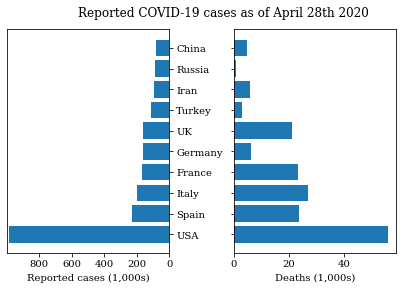

In [34]:
# Total number of confirmed cases and deaths
df.loc[ df.alpha2Code == "RU","Country"] = "Russia"
df.loc[ df.alpha2Code == "IR","Country"] = "Iran"
df.loc[ df.alpha2Code == "US","Country"] = "USA"
df.loc[ df.alpha2Code == "GB","Country"] = "UK"

from matplotlib import rcParams
rcParams['font.family'] = ' serif'

df_plot = df.sort_values('Covid19_total',ascending=False)[:10]
y1 = df_plot['Covid19_total']/1000
y2 = df_plot['Covid19_deaths']/1000
x = df_plot['Country']

fig, ax= plt.subplots(ncols=2, sharey=True, figsize=(8,4))
ax[0].barh(x,y1)
ax[0].set_xlim([1.01*y1.max(),0])
ax[0].yaxis.tick_right()
ax[1].barh(x,y2)
ax[0].set_xlabel('Reported cases (1,000s)')
ax[1].set_xlabel('Deaths (1,000s)')
#fig.tight_layout()
fig.subplots_adjust(wspace=0.4, right=0.8, top=0.9)
fig.suptitle("Reported COVID-19 cases as of April 28th 2020")
fig.savefig('fig_total_cases.svg')

<a id='step2b'></a>
## 3.2 Case fatality rate

In [35]:
# COMPUTE CFR FOR ALL COUNTRIES WITH MORE THAN 10,000 CAES
print("Fatality rate")
print(f"   Sample size: {df.shape[0]}")
print(f"   Countries mean (std): {df['Covid19_fatality'].mean():.3f} +- {df['Covid19_fatality'].std():.3f}")
print(f"   Countries min/max: {df['Covid19_fatality'].min():.3f} / {df['Covid19_fatality'].max():.3f}")

Fatality rate
   Sample size: 35
   Countries mean (std): 0.054 +- 0.044
   Countries min/max: 0.001 / 0.154


In [36]:
# Top-10 countries per case fatality rate
df_table = df.sort_values('Covid19_fatality',ascending=False)[["Country","Covid19_total","Covid19_deaths","Covid19_fatality"]].head(10)
df_table = df_table.round({"Covid19_fatality": 3})
df_table["Covid19_fatality"] = 100*df_table["Covid19_fatality"]
df_table = df_table.rename(columns={
    "Covid19_total": "Confirmed",
    "Covid19_deaths": "Deaths",
    "Covid19_fatality": "CFR (%)"
})
df_table.set_index("Country", inplace=True)
df_table

,Confirmed,Deaths,CFR (%)
Country,,,
Belgium,46687,7207,15.4
France,165963,23327,14.1
Italy,199414,26977,13.5
UK,158348,21157,13.4
Sweden,18926,2274,12.0
Netherlands,38440,4534,11.8
Spain,229422,23521,10.3
Mexico,15529,1434,9.2
Brazil,67446,4603,6.8


In [37]:
# CHECK CFR FOR GERMANY AND CHINA
df.query("alpha2Code == 'DE' | alpha2Code == 'CN'")

,Country,alpha2Code,Covid19_total,Covid19_deaths,Covid19_recovered,Covid19_active,Covid19_fatality
4,Germany,DE,158758,6126,114500,44258,0.038587
9,China,CN,83918,4637,78374,5544,0.055256


<a id='step2c'></a>
## 3.3 CFR correlation of indicators

In [38]:
# Compute correlations to case fatality rate of COVID-19
corrMatrix = df_agg.corr(method='spearman')
corrMatrix['Case fatality rate COVID-19'].sort_values(ascending=False)[1:]

Total number of COVID-19 deaths                                                0.736264
Total number of COVID-19 active                                                0.591209
Influenza (Number of total deaths) 2015                                        0.532967
Total number of COVID-19 confirmed                                             0.507692
Asthma (Number of total deaths) 2015                                           0.357143
Expenditure on health (Government/compulsory schemes, share of GDP)            0.274725
Population                                                                     0.270330
Total hospital employment (per 1 000 population) 2015                          0.263636
Chronic obstructive Pulmonary diseases (Number of total deaths) 2015           0.247253
Pneumonia (Number of total deaths) 2015                                        0.219780
Expenditure on health (All financing schemes, share of GDP)                    0.087912
Practising nurses (per 1 000 pop

In [39]:
# CHECK INDICATORS WITH HIGHTEST ANTI-CORRELATION WITH CFR
df_agg[['Country','Case fatality rate COVID-19','Hospital beds (per 1,000 people) 2010','Practising physicians (per 1 000 population) 2015']].sort_values('Case fatality rate COVID-19',ascending=False)

,Country,Case fatality rate COVID-19,"Hospital beds (per 1,000 people) 2010",Practising physicians (per 1 000 population) 2015
5,Belgium,0.154368,6.5,3.02
2,France,0.140555,6.6,3.12
1,Italy,0.135281,3.6,3.84
4,United Kingdom,0.133611,3.0,2.77
10,Sweden,0.120152,2.7,4.27
6,Netherlands,0.117950,NaN,3.49
0,Spain,0.102523,3.2,3.85
7,Switzerland,0.057091,5.0,4.20
13,Romania,0.056531,6.3,NaN
9,Ireland,0.056087,3.0,2.86


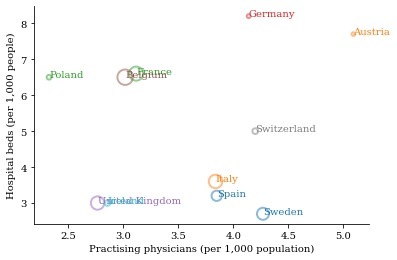

In [40]:
# VISUALIZE INDICATORS WITH HIGHTEST ANTI-CORRELATION WITH CFR
fig, ax= plt.subplots(1,figsize=(6,4))


for ix in df_agg.index:
    x = df_agg.loc[ix,'Practising physicians (per 1 000 population) 2015']
    y = df_agg.loc[ix,'Hospital beds (per 1,000 people) 2010']
    s = df_agg.loc[ix,'Case fatality rate COVID-19']
    
    country = df_agg.loc[ix,"Country"]
    ax.scatter(x,y,s=(100*s)**2,
               marker='o',
               facecolors="None",
               edgecolors=f'C{ix}',
               lw=2,
               alpha=0.5)
    ax.annotate(country, (x, y),c=f'C{ix}')

ax.set_ylabel('Hospital beds (per 1,000 people)')
ax.set_xlabel('Practising physicians (per 1,000 population)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.savefig('fig_scatter.svg',dpi=200)

[Back to top](#top)

---
<a id='step3'></a>
## 4. Analysis and conclusions

**Question 1: What is the case fatality rate (CFR) of COVID-19?**

The average case fatality rate (CFR) for COVID-19 for the 35 countries with number of reported cases above 10,000 (as for 28th April 2020) was observed to be 5.4%.


**Question 2: Is there a significant variation of CFR for COVID-19 among different countries?**

The average CFR is highly affected by the quality of the reports from each country. For a few cases (e.g., Russia), the reported deaths are likely undereported. A significant variation of CFR among countries is observed. In particular, 7 countries were observed to have a CFR above 10% with the highest value of 15.4% for Belgian. All the 7 countries with CFR above 10% are European and this values is significantly differenet from Germany, which is among the top-5 affect countris as per number of reported cases.

**Question 3: What country-specific features might affect the case fatality rate?**

To consider for possible country-specific features affecting the case fatality rate, the correlation of health indicators with CFR was calculated. In particular, the results suggest that health indicators like number of hospital beds and physicians could explain why Germany is coping with the COVID-19 outbread significantly better than its neighbor countries.

Only aggregated data were considered in the analysis, without taking into account the time evolution of the active cases. Further relevant aspects which need to be also account are the impact of the timeline of number of active cases as well as the effect of number of tests performed.

[Back to top](#top)

---
<a id='step4'></a>
## 5. Resources

The following APIs were used to pull the data:
- https://api.covid19api.com/
- https://restcountries.eu/
- https://corona-api.com
- http://api.worldbank.org
- https://stats.oecd.org/

[Back to top](#top)